# homework1：实战FashionMNIST分类，重点是理解，理解模型的运算过程

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.2.1
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备1，为了看灰度图片

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms


# 定义数据集的变换
transform = transforms.Compose([
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [3]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]

In [4]:
# 显示图片，这里需要把transforms.ToTensor(),进行归一化注释掉，否则是不行的
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)


    print("图像大小:", img.size)
    print("图像模式:", img.mode)


    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)
show_img_content(img) #这里必须把上面的 transforms.ToTensor(), # 转换为tensor，进行归一化注释掉，否则是不行的

图像大小: (28, 28)
图像模式: L
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 13, 73, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 36, 136, 127, 62, 54, 0, 0, 0, 1, 3, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 102, 204, 176, 134, 144, 123, 23, 0, 0, 0, 0, 12, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 236, 207, 178, 107, 156, 161, 109, 64, 23, 77, 130, 72, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 69, 207, 223, 218, 216, 216, 163, 127, 121, 122, 146, 141, 88, 172, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 200, 232, 232, 233, 229, 223, 223, 215, 213, 164, 127, 123, 196, 229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 225, 216, 223, 228, 235, 227, 224, 222, 224, 221, 223, 245, 173, 0, 0, 0, 

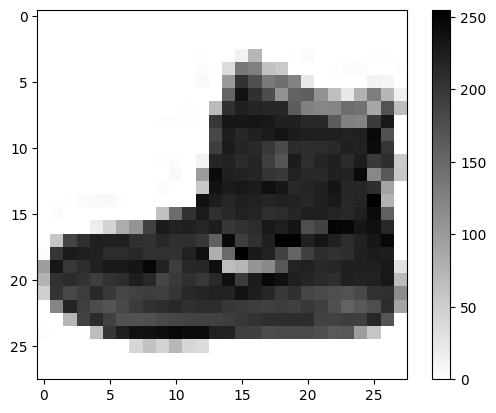

In [5]:
#这个代码必须是注释了上面的 transforms.ToTensor()才能够运行的
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary") # 显示图片
    plt.colorbar() # 显示颜色条
    plt.show()


show_single_image(img)

数据准备2，为训练做准备

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms


# 定义数据集的变换
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为tensor，进行归一化
    # transforms.Normalize(mean, std) # 标准化，mean和std是数据集的均值和方差
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [7]:
img, label = train_ds[0]
img.shape  #img这时是一个tensor，shape=(1, 28, 28)

torch.Size([1, 28, 28])

In [8]:
#计算均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:  # 遍历每张图片,img.shape=[1,28,28]
        mean += img.mean(dim=(1, 2))  # 计算每张图片的均值，dim=(1, 2)表示计算每张图片的每一个像素的均值,行列共同求均值
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


print(cal_mean_std(train_ds))

(tensor([0.2860]), tensor([0.3205]))


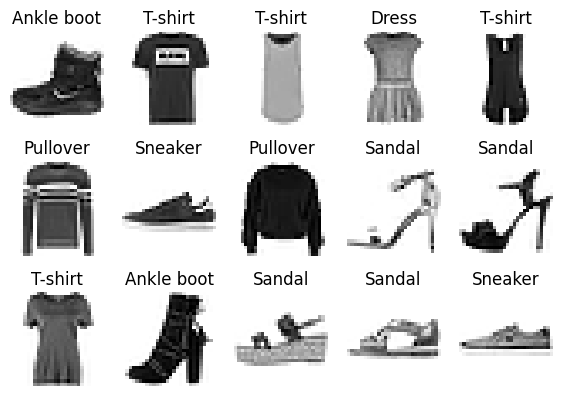

In [9]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    # 确保打印的图片数量不超过数据集的总样本数
    assert n_rows * n_cols < len(train_ds)
    
    # 创建一个图像窗口，设置图像窗口的大小
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  # 宽度为n_cols * 1.4，高度为n_rows * 1.6
    
    # 遍历每一行
    for row in range(n_rows):
        # 遍历每一列
        for col in range(n_cols):
            # 计算当前图片的索引，从0开始
            index = n_cols * row + col
            
            # 在图像窗口中创建子图，n_rows行，n_cols列，当前子图的位置为index+1（因为subplot从1开始计数）
            plt.subplot(n_rows, n_cols, index + 1)
            
            # 从数据集中获取图像和标签
            img_arr, label = train_ds[index]
            
            # 将图像的通道维度从 (C, H, W) 转换为 (H, W, C)，以便matplotlib可以正确显示
            img_arr = np.transpose(img_arr, (1, 2, 0))
            
            # 显示图像，使用二值颜色映射（cmap="binary"），并使用最近邻插值（interpolation='nearest'）
            plt.imshow(img_arr, cmap="binary", interpolation='nearest')
            
            # 关闭坐标轴显示
            plt.axis('off')
            
            # 在图像上方显示对应的类别名称
            plt.title(class_names[label])
    
    # 显示所有子图
    plt.show()
    

# 已知的图片类别
# 标签信息可以在以下路径找到：https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']  # 0-9分别代表的类别

# 打印前15个样本，3行5列
show_imgs(3, 5, train_ds, class_names)

In [10]:
# 从数据集创建 DataLoader
# DataLoader 是 PyTorch 提供的一个工具，用于批量加载数据，支持多线程数据加载和数据洗牌等功能

# 创建训练集的 DataLoader
train_loader = torch.utils.data.DataLoader(
    train_ds,          # 训练数据集
    batch_size=32,     # 每个批次的大小为 32，即每次从数据集中加载 32 个样本
    shuffle=True       # 在每个 epoch 开始时打乱数据顺序，确保模型训练时数据的随机性
)

# 创建验证集的 DataLoader
val_loader = torch.utils.data.DataLoader(
    test_ds,           # 验证数据集（或测试数据集）
    batch_size=32,     # 每个批次的大小为 32
    shuffle=False      # 验证集不需要打乱数据顺序，保持数据的原始顺序
)

在PyTorch中，`DataLoader`是一个迭代器，它封装了数据的加载和预处理过程，使得在训练机器学习模型时可以方便地批量加载数据。`DataLoader`主要负责以下几个方面：

1. **批量加载数据**：`DataLoader`可以将数据集（Dataset）切分为更小的批次（batch），每次迭代提供一小批量数据，而不是单个数据点。这有助于模型学习数据中的统计依赖性，并且可以更高效地利用GPU等硬件的并行计算能力。

2. **数据打乱**：默认情况下，`DataLoader`会在每个epoch（训练周期）开始时打乱数据的顺序。这有助于模型训练时避免陷入局部最优解，并且可以提高模型的泛化能力。

3. **多线程数据加载**：`DataLoader`支持多线程（通过参数`num_workers`）来并行地加载数据，这可以显著减少训练过程中的等待时间，尤其是在处理大规模数据集时。

4. **数据预处理**：`DataLoader`可以与`transforms`结合使用，对加载的数据进行预处理，如归一化、标准化、数据增强等操作。

5. **内存管理**：`DataLoader`负责管理数据的内存使用，确保在训练过程中不会耗尽内存资源。

6. **易用性**：`DataLoader`提供了一个简单的接口，可以很容易地集成到训练循环中。



定义模型

In [11]:
# 定义一个神经网络模型类，继承自 PyTorch 的 nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        # 调用父类 nn.Module 的初始化方法，确保子类继承父类的属性和方法
        super().__init__()
        
        # 定义展平层，将多维输入张量展平为一维张量
        # 例如，将形状为 [batch_size, 1, 28, 28] 的张量展平为 [batch_size, 784]
        self.flatten = nn.Flatten()
        
        # 定义一个顺序容器，包含多个线性层和激活函数
        self.linear_relu_stack = nn.Sequential(
            # 第一个全连接层，输入特征数为 784，输出特征数为 300
            nn.Linear(784, 300),  # in_features=784, out_features=300
            # ReLU 激活函数，引入非线性
            nn.ReLU(),
            # 第二个全连接层，输入特征数为 300，输出特征数为 100
            nn.Linear(300, 100),  # 隐藏层神经元数为 100
            # ReLU 激活函数
            nn.ReLU(),
            # 第三个全连接层，输入特征数为 100，输出特征数为 10
            nn.Linear(100, 10),   # 输出层神经元数为 10，对应 10 个类别
        )

    # 定义前向传播方法，描述数据如何通过网络
    def forward(self, x):
        # 输入 x 的形状为 [batch_size, 1, 28, 28]，其中 1 是通道数（灰度图像）
        x = self.flatten(x)  # 展平操作，将输入张量展平为 [batch_size, 784]
        # print(f'x.shape--{x.shape}')  # 可以打印展平后的形状以调试
        
        # 将展平后的数据通过线性层和激活函数堆栈
        logits = self.linear_relu_stack(x)
        # logits 的形状为 [batch_size, 10]，表示每个样本的 10 个类别的原始分数（未经过 softmax）
        
        # 返回 logits
        return logits


# 创建神经网络模型的实例
model = NeuralNetwork()

In [12]:
# 看看网络结构
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [13]:
#为了查看模型运算的tensor尺寸
x = torch.randn(32, 1, 28, 28)
print(x.shape)
logits = model(x)
print(logits.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [14]:
for name, param in model.named_parameters(): # 打印模型参数
      print(name, param.shape)

linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])


In [15]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数,requires_grad=True

[Parameter containing:
 tensor([[ 0.0282, -0.0309,  0.0166,  ..., -0.0173, -0.0137,  0.0200],
         [-0.0114, -0.0189,  0.0215,  ...,  0.0319,  0.0001, -0.0348],
         [ 0.0058, -0.0205, -0.0264,  ..., -0.0227,  0.0191, -0.0038],
         ...,
         [ 0.0123,  0.0044, -0.0112,  ...,  0.0171,  0.0289, -0.0064],
         [ 0.0142,  0.0321,  0.0062,  ...,  0.0316, -0.0092, -0.0042],
         [-0.0256, -0.0213,  0.0111,  ..., -0.0019, -0.0154, -0.0237]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0177, -0.0177, -0.0120,  0.0071,  0.0347,  0.0017, -0.0075, -0.0277,
         -0.0163,  0.0179,  0.0219,  0.0195, -0.0020,  0.0266, -0.0162, -0.0124,
          0.0253,  0.0148, -0.0237, -0.0312, -0.0321,  0.0053,  0.0010,  0.0012,
          0.0290,  0.0175,  0.0032,  0.0170, -0.0105, -0.0110, -0.0344,  0.0234,
          0.0263, -0.0149, -0.0224,  0.0229, -0.0283, -0.0075,  0.0069, -0.0047,
         -0.0343, -0.0110, -0.0236,  0.0235,  0.0057,  0.0316,  0.0279, -0.0317

In [16]:
# model.state_dict()  # 这种方法用于保存模型参数，看能看见参数属于模型的哪一部分

训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [17]:
# 1. 定义损失函数，采用交叉熵损失
# nn.CrossEntropyLoss() 是 PyTorch 提供的交叉熵损失函数
# 它内部会先对模型的输出（logits）进行 softmax 操作，然后计算交叉熵损失
# 适用于多分类问题
loss_fct = nn.CrossEntropyLoss()

# 2. 定义优化器，采用随机梯度下降（SGD）
# torch.optim.SGD 是 PyTorch 提供的随机梯度下降优化器
# 参数说明：
# - model.parameters(): 需要优化的模型参数（即模型中的权重和偏置）
# - lr=0.001: 学习率（learning rate），控制参数更新的步长
# - momentum=0.9: 动量（momentum），加速梯度下降并减少震荡
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
# 导入准确率计算函数
from sklearn.metrics import accuracy_score

# 使用 @torch.no_grad() 装饰器，禁止反向传播，节省内存
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    # 初始化列表，用于记录损失、预测值和真实标签
    loss_list = []  # 记录每个批次的损失
    pred_list = []  # 记录每个批次的预测值
    label_list = []  # 记录每个批次的真实标签

    # 遍历数据加载器中的每个批次
    for datas, labels in dataloader:  # 假设 dataloader 有 10000 个样本，batch_size=32，则共有 312 个批次
        # 将数据转移到设备（如 GPU）上
        datas = datas.to(device)  # 将输入数据转移到 GPU
        labels = labels.to(device)  # 将标签转移到 GPU

        # 前向计算：通过模型获取 logits（未经过 softmax 的输出）
        logits = model(datas)

        # 计算损失：使用损失函数计算模型输出与真实标签之间的误差
        loss = loss_fct(logits, labels)  # 验证集损失，loss 是一个标量值
        loss_list.append(loss.item())  # 记录损失，将张量转换为 Python 数值

        # 获取预测值：通过 argmax 找到 logits 中最大值的索引，即预测的类别
        preds = logits.argmax(axis=-1)  # 验证集预测，返回每个样本的预测类别索引
        # print(preds)  # 可以打印预测值以调试

        # 将预测值和真实标签从 GPU 转移到 CPU，并转换为 NumPy 数组，最后转换为列表
        pred_list.extend(preds.cpu().numpy().tolist())  # 将 PyTorch 张量转换为 NumPy 数组，再转换为列表
        label_list.extend(labels.cpu().numpy().tolist())  # 同上

    # 计算准确率：使用 sklearn 的 accuracy_score 函数计算预测值与真实标签的准确率
    acc = accuracy_score(label_list, pred_list)  # 计算准确率

    # 返回平均损失和准确率
    return np.mean(loss_list), acc  # 返回所有批次的平均损失和准确率

In [19]:
# 训练函数
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    # 初始化记录字典，用于保存训练和验证过程中的损失和准确率
    record_dict = {
        "train": [],  # 记录训练集的信息
        "val": []     # 记录验证集的信息
    }
    
    global_step = 0  # 全局步数，用于记录训练的进度
    model.train()    # 将模型设置为训练模式

    # 使用 tqdm 创建一个进度条，总长度为 epoch * len(train_loader)
    with tqdm(total=epoch * len(train_loader)) as pbar:  # 60000/32=1875，20个epoch的总步数为1875*20
        for epoch_id in range(epoch):  # 遍历每个epoch
            # 训练阶段
            for datas, labels in train_loader:  # 遍历训练集的每个批次，60000/32=1875个批次
                datas = datas.to(device)  # 将输入数据转移到GPU，形状为 [batch_size, 1, 28, 28]
                labels = labels.to(device)  # 将标签转移到GPU，形状为 [batch_size]

                # 清空梯度
                optimizer.zero_grad()

                # 模型前向计算，获取 logits（未经过 softmax 的输出）
                logits = model(datas)

                # 计算损失
                loss = loss_fct(logits, labels)

                # 反向传播，计算梯度
                loss.backward()  # loss 对模型参数求导

                # 更新模型参数
                optimizer.step()  # 使用优化器更新模型参数（权重和偏置）

                # 获取预测值
                preds = logits.argmax(axis=-1)  # 对 logits 进行 argmax 操作，获取预测类别索引

                # 计算准确率
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())  # 将标签和预测值转移到 CPU 并计算准确率

                # 将损失转移到 CPU 并转换为 Python 数值
                loss = loss.cpu().item()

                # 记录训练信息
                record_dict["train"].append({
                    "loss": loss,  # 当前批次的损失
                    "acc": acc,    # 当前批次的准确率
                    "step": global_step  # 当前全局步数
                })

                # 每隔 eval_step 步进行一次验证
                if global_step % eval_step == 0:
                    model.eval()  # 将模型设置为评估模式
                    # 调用 evaluating 函数计算验证集的损失和准确率
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    # 记录验证信息
                    record_dict["val"].append({
                        "loss": val_loss,  # 验证集的损失
                        "acc": val_acc,    # 验证集的准确率
                        "step": global_step  # 当前全局步数
                    })
                    model.train()  # 将模型重新设置为训练模式

                # 更新全局步数
                global_step += 1

                # 更新进度条
                pbar.update(1)  # 进度条前进一步
                pbar.set_postfix({"epoch": epoch_id})  # 在进度条中显示当前 epoch

    # 返回记录字典
    return record_dict


# 设置训练的 epoch 数
epoch = 20  # 可以改为 40 或其他值

# 将模型转移到 GPU
model = model.to(device)

# 调用训练函数，开始训练
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/37500 [00:00<?, ?it/s]

In [20]:
record["train"][-5:]

[{'loss': 0.33762267231941223, 'acc': 0.875, 'step': 37495},
 {'loss': 0.35667529702186584, 'acc': 0.9375, 'step': 37496},
 {'loss': 0.20788542926311493, 'acc': 0.9375, 'step': 37497},
 {'loss': 0.4300464689731598, 'acc': 0.78125, 'step': 37498},
 {'loss': 0.31344711780548096, 'acc': 0.875, 'step': 37499}]

In [21]:
record["val"][-5:]

[{'loss': np.float64(0.3564875004723811), 'acc': 0.8726, 'step': 33000},
 {'loss': np.float64(0.35596657625307293), 'acc': 0.8728, 'step': 34000},
 {'loss': np.float64(0.35776125546842336), 'acc': 0.8707, 'step': 35000},
 {'loss': np.float64(0.3588377846220431), 'acc': 0.8699, 'step': 36000},
 {'loss': np.float64(0.34980692187199197), 'acc': 0.875, 'step': 37000}]

step
0        0.09375
1000     0.78125
2000     0.71875
3000     0.68750
4000     0.81250
5000     0.87500
6000     0.78125
7000     0.84375
8000     0.87500
9000     0.87500
10000    0.75000
11000    0.87500
12000    0.78125
13000    0.78125
14000    0.87500
15000    0.84375
16000    0.90625
17000    0.87500
18000    0.81250
19000    0.87500
20000    0.84375
21000    0.81250
22000    0.96875
23000    0.87500
24000    0.84375
25000    0.93750
26000    0.96875
27000    0.87500
28000    0.93750
29000    0.87500
30000    0.87500
31000    0.93750
32000    0.87500
33000    0.87500
34000    0.84375
35000    0.93750
36000    0.84375
37000    0.87500
Name: acc, dtype: float64
step
0        0.1177
1000     0.6926
2000     0.7785
3000     0.8043
4000     0.8144
5000     0.8174
6000     0.8186
7000     0.8316
8000     0.8311
9000     0.8349
10000    0.8260
11000    0.8373
12000    0.8455
13000    0.8482
14000    0.8478
15000    0.8513
16000    0.8516
17000    0.8301
18000    0.8429
19000    0.859

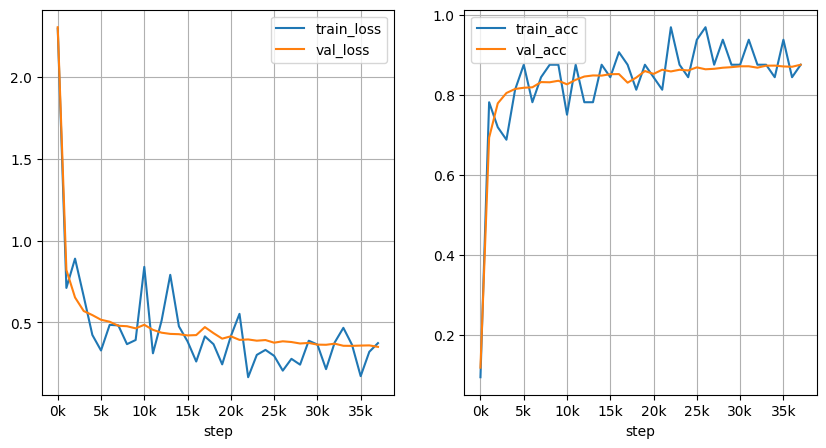

In [22]:
# 画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=1000):
    # 构建 DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    last_step = train_df.index[-1]  # 获取最后一步的步数

    # 打印训练和验证的准确率
    print(train_df['acc'])
    print(val_df['acc'])

    # 绘制图形
    fig_num = len(train_df.columns)  # 画几张图, 分别是损失和准确率
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    
    for idx, item in enumerate(train_df.columns):
        # 绘制训练和验证曲线
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()  # 显示网格
        axs[idx].legend()  # 显示图例
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))  # 设置x轴刻度
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000)))  # 设置x轴标签
        axs[idx].set_xlabel("step")  # 设置x轴标签为“step”
    
    plt.show()  # 显示图形

# 调用函数绘制学习曲线
plot_learning_curves(record)

In [23]:
# dataload for evaluating

model.eval() # 进入评估模式
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3507
accuracy: 0.8753
